## 1. Import Libraries
We import standard data manipulation libraries (Pandas, NumPy) and visualization tools (Matplotlib, Seaborn). 
LightGBM is chosen as the modeling library due to its efficiency with large datasets and ability to handle categorical features and missing values natively.
We also set configuration options to ignore warnings and display all columns in the DataFrame.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, precision_recall_curve, roc_curve, auc
import lightgbm as lgb
import warnings
import gc
import os
from scipy import stats

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Load Data
The dataset is split into two parts: `transaction` (transaction details like amount, card, time) and `identity` (network and device info). 
These are loaded separately for both the training and test sets.

In [2]:
# Define data path
DATA_PATH = '../data/IEEE-CIS'

# Load transaction data
print("Loading transaction data...")
train_transaction = pd.read_csv(os.path.join(DATA_PATH, 'train_transaction.csv'))
test_transaction = pd.read_csv(os.path.join(DATA_PATH, 'test_transaction.csv'))

# Load identity data
print("Loading identity data...")
train_identity = pd.read_csv(os.path.join(DATA_PATH, 'train_identity.csv'))
test_identity = pd.read_csv(os.path.join(DATA_PATH, 'test_identity.csv'))

print(f"\nTrain Transaction Shape: {train_transaction.shape}")
print(f"Test Transaction Shape: {test_transaction.shape}")
print(f"Train Identity Shape: {train_identity.shape}")
print(f"Test Identity Shape: {test_identity.shape}")

Loading transaction data...
Loading identity data...

Train Transaction Shape: (590540, 394)
Test Transaction Shape: (506691, 393)
Train Identity Shape: (144233, 41)
Test Identity Shape: (141907, 41)


## 3. Merge Transaction and Identity Data
We perform a **Left Join** on `TransactionID`. 
Note that not all transactions have associated identity data (identity data is usually only available for specific transaction types or risk levels).
After merging, we delete the original dataframes and run garbage collection (`gc.collect()`) to free up RAM, which is critical for large datasets.

In [3]:
# Merge transaction and identity data on TransactionID
train = train_transaction.merge(train_identity, on='TransactionID', how='left')
test = test_transaction.merge(test_identity, on='TransactionID', how='left')

print(f"Train Shape after merge: {train.shape}")
print(f"Test Shape after merge: {test.shape}")

# Free memory
del train_transaction, test_transaction, train_identity, test_identity
gc.collect()

Train Shape after merge: (590540, 434)
Test Shape after merge: (506691, 433)


0

## 4. Exploratory Data Analysis (EDA)
Here we analyze the class imbalance. Fraud detection datasets are typically highly imbalanced (few frauds vs. many legitimate transactions).
We visualize the distribution of `isFraud` using bar and pie charts to understand the baseline probability.
We also categorize columns into groups (C, D, M, V, ID) to help organize our feature engineering strategy later.

Target Distribution:
isFraud
0    569877
1     20663
Name: count, dtype: int64

Fraud Rate: 3.50%


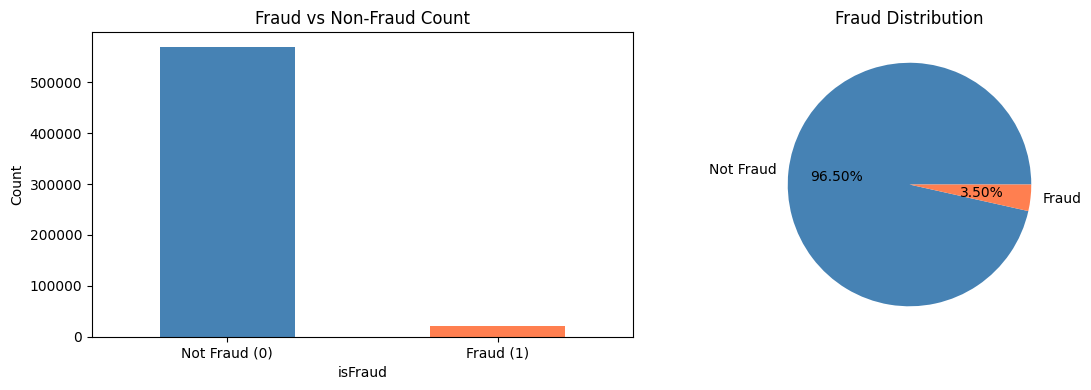


Column Categories:
- C columns (counting): ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14']
- D columns (timedelta): ['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'DeviceType', 'DeviceInfo']
- M columns (match): ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']
- V columns (Vesta features): 339 columns
- id columns: ['id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']


In [4]:
# Check target distribution
print("Target Distribution:")
print(train['isFraud'].value_counts())
print(f"\nFraud Rate: {train['isFraud'].mean() * 100:.2f}%")

# Visualize target distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

train['isFraud'].value_counts().plot(kind='bar', ax=axes[0], color=['steelblue', 'coral'])
axes[0].set_title('Fraud vs Non-Fraud Count')
axes[0].set_xlabel('isFraud')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['Not Fraud (0)', 'Fraud (1)'], rotation=0)

train['isFraud'].value_counts().plot(kind='pie', ax=axes[1], autopct='%1.2f%%', 
                                     colors=['steelblue', 'coral'], labels=['Not Fraud', 'Fraud'])
axes[1].set_title('Fraud Distribution')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

# Column categories
print("\nColumn Categories:")
print(f"- C columns (counting): {[c for c in train.columns if c.startswith('C')]}")
print(f"- D columns (timedelta): {[c for c in train.columns if c.startswith('D')]}")
print(f"- M columns (match): {[c for c in train.columns if c.startswith('M')]}")
print(f"- V columns (Vesta features): {len([c for c in train.columns if c.startswith('V')])} columns")
print(f"- id columns: {[c for c in train.columns if c.startswith('id_')]}")

## 5. Feature Engineering - Core Functions (Memory Reduction)
This function is crucial. Pandas default types (`int64`, `float64`) use more memory than necessary. 
We iterate through every column and "downcast" the data type (e.g., if a number fits in `int8`, use `int8` instead of `int64`).
This can reduce memory usage by 50-70%, allowing us to train models on larger datasets without crashing.

In [5]:
import pandas as pd
import numpy as np

def reduce_mem_usage(df, verbose=True):
    start_mem = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:
        # Sử dụng kiểm tra kiểu số của Pandas để tránh lỗi StringDtype
        if pd.api.types.is_numeric_dtype(df[col]):
            c_min = df[col].min()
            c_max = df[col].max()
            col_type = df[col].dtype
            
            # Kiểm tra nếu là kiểu Integer
            if pd.api.types.is_integer_dtype(df[col]):
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                else:
                    df[col] = df[col].astype(np.int64)
            # Kiểm tra nếu là kiểu Float
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        
        # KHÔNG chuyển sang category ở đây nữa
        # Vì sẽ gây lỗi khi fillna với giá trị mới
        # Việc chuyển category sẽ được thực hiện sau khi feature engineering hoàn tất

    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print(f'Memory usage: {start_mem:.2f} MB -> {end_mem:.2f} MB ({100 * (start_mem - end_mem) / start_mem:.1f}% reduction)')
    return df

In [6]:
reduce_mem_usage(train)

Memory usage: 1955.37 MB -> 1044.70 MB (46.6% reduction)


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.500000,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.000000,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,M0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.000000,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,315.0,NaN,NaN,NaN,315.0,T,T,T,M0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.000000,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,84.0,NaN,NaN,NaN,NaN,111.0,NaN,NaN,NaN,M0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.000000,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,3577535,0,15811047,49.000000,W,6550,NaN,150.0,visa,226.0,debit,272.0,87.0,48.0,NaN,NaN,NaN,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,3.0,2.0,29.0,29.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN,56.0,56.0,NaN,NaN,NaN,56.0,T,T,T,M0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590536,3577536,0,15811049,39.500000,W,10444,225.0,150.0,mastercard,224.0,debit,204.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.0,T,F,F,M0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

## 6. Feature Engineering - Transaction Amount Features
Fraud patterns often hide in the specific amounts of transactions.
1. **Log Transform:** Normalizes the skewed distribution of money.
2. **Decimal extraction:** Fraudsters might use automated bots resulting in specific decimal patterns, or round numbers (no cents).
3. **Cents:** Extracts just the `.99` or `.95` part, which is common in retail but might behave differently in fraud.

In [7]:
def create_transaction_amount_features(df):
    """Create features based on transaction amount"""
    print("Creating transaction amount features...")
    
    # Log transformation
    df['TransactionAmt_Log'] = np.log1p(df['TransactionAmt'])
    
    # Decimal part (cents) - often fraudsters use round numbers
    df['TransactionAmt_decimal'] = ((df['TransactionAmt'] - df['TransactionAmt'].astype(int)) * 1000).astype(int)
    
    # Is round amount (no cents)
    df['TransactionAmt_is_round'] = (df['TransactionAmt'] == df['TransactionAmt'].astype(int)).astype(int)
    
    # Amount bins
    df['TransactionAmt_bin'] = pd.cut(df['TransactionAmt'], 
                                     bins=[0, 50, 100, 200, 500, 1000, 5000, 10000, np.inf],
                                     labels=[0, 1, 2, 3, 4, 5, 6, 7]).astype(float)
    
    # Cents value
    df['TransactionAmt_cents'] = (df['TransactionAmt'] * 100 % 100).astype(int)
    
    # Common fraud amounts (ends in .00, .99, .95)
    df['TransactionAmt_ends_00'] = (df['TransactionAmt_cents'] == 0).astype(int)
    df['TransactionAmt_ends_99'] = (df['TransactionAmt_cents'] == 99).astype(int)
    df['TransactionAmt_ends_95'] = (df['TransactionAmt_cents'] == 95).astype(int)
    
    return df

# Apply
train = create_transaction_amount_features(train)
test = create_transaction_amount_features(test)

Creating transaction amount features...
Creating transaction amount features...


## 7. Feature Engineering - Time Features
`TransactionDT` is a timedelta (seconds) from a reference date. It is not an actual timestamp.
We convert this into:
1. **Hour of Day:** Fraud often happens at night (e.g., 2 AM - 5 AM) when valid users are asleep.
2. **Day of Week:** Weekends might have different risk profiles than weekdays.
3. **Business Hours:** Flagging transactions made during standard working hours vs. off-hours.

In [8]:
def create_time_features(df):
    """Create time-based features from TransactionDT"""
    print("Creating time features...")
    
    # TransactionDT is seconds from a reference point
    # Convert to interpretable time units
    
    # Hour of day (0-23)
    df['Transaction_hour'] = np.floor(df['TransactionDT'] / 3600) % 24
    
    # Day of week (0-6)
    df['Transaction_dow'] = np.floor(df['TransactionDT'] / (3600 * 24)) % 7
    
    # Day of month approximation
    df['Transaction_dom'] = np.floor(df['TransactionDT'] / (3600 * 24)) % 30
    
    # Week number
    df['Transaction_week'] = np.floor(df['TransactionDT'] / (3600 * 24 * 7))
    
    # Is weekend
    df['Transaction_is_weekend'] = (df['Transaction_dow'] >= 5).astype(int)
    
    # Time of day categories
    df['Transaction_time_of_day'] = pd.cut(df['Transaction_hour'], 
                                            bins=[-1, 6, 12, 18, 24],
                                            labels=[0, 1, 2, 3]).astype(float)  # night, morning, afternoon, evening
    
    # Is night (00:00 - 06:00) - higher fraud risk
    df['Transaction_is_night'] = ((df['Transaction_hour'] >= 0) & (df['Transaction_hour'] < 6)).astype(int)
    
    # Is business hours (09:00 - 17:00)
    df['Transaction_is_business_hours'] = ((df['Transaction_hour'] >= 9) & (df['Transaction_hour'] < 17)).astype(int)
    
    return df

# Apply
train = create_time_features(train)
test = create_time_features(test)

Creating time features...
Creating time features...


## 8. Feature Engineering - Card Features
Individual card features (like `card1` issuer, `card4` network) are weak on their own.
By performing **Feature Interaction (concatenation)**, we create stronger signatures.
Example: `card1_addr1` combines the card issuer with the billing region. A specific bank card used in an unusual region might be highly predictive of fraud.

In [9]:
def create_card_features(df):
    """Create features based on card information"""
    print("Creating card features...")
    
    # Card combination features
    card_cols = ['card1', 'card2', 'card3', 'card4', 'card5', 'card6']
    
    for col in card_cols:
        if col in df.columns:
            # Fill NaN for string operations
            df[col] = df[col].fillna(-999)
    
    # Card1 + Card2 combination
    if 'card1' in df.columns and 'card2' in df.columns:
        df['card1_card2'] = df['card1'].astype(str) + '_' + df['card2'].astype(str)
    
    # Card type combinations
    if 'card4' in df.columns and 'card6' in df.columns:
        df['card4_card6'] = df['card4'].astype(str) + '_' + df['card6'].astype(str)
    
    # Card + Address combinations
    if 'card1' in df.columns and 'addr1' in df.columns:
        df['card1_addr1'] = df['card1'].astype(str) + '_' + df['addr1'].astype(str)
    
    if 'card1' in df.columns and 'addr2' in df.columns:
        df['card1_addr2'] = df['card1'].astype(str) + '_' + df['addr2'].astype(str)
    
    if 'card2' in df.columns and 'addr1' in df.columns:
        df['card2_addr1'] = df['card2'].astype(str) + '_' + df['addr1'].astype(str)
    
    # Card + Product combinations
    if 'card1' in df.columns and 'ProductCD' in df.columns:
        df['card1_ProductCD'] = df['card1'].astype(str) + '_' + df['ProductCD'].astype(str)
    
    if 'card2' in df.columns and 'ProductCD' in df.columns:
        df['card2_ProductCD'] = df['card2'].astype(str) + '_' + df['ProductCD'].astype(str)
    
    # Card + Time combinations
    if 'card1' in df.columns and 'Transaction_hour' in df.columns:
        df['card1_hour'] = df['card1'].astype(str) + '_' + df['Transaction_hour'].astype(int).astype(str)
    
    if 'card1' in df.columns and 'Transaction_dow' in df.columns:
        df['card1_dow'] = df['card1'].astype(str) + '_' + df['Transaction_dow'].astype(int).astype(str)
    
    return df

# Apply
train = create_card_features(train)
test = create_card_features(test)

Creating card features...
Creating card features...


## 9. Feature Engineering - Email Features
Emails provide rich data.
1. **Vendor Mapping:** We map domains to their providers (e.g., `gmail.com` -> `google`).
2. **Suffix Extraction:** `email.com` vs `email.co.uk`.
3. **Matching:** Does the Purchaser email (`P_emaildomain`) match the Recipient email (`R_emaildomain`)? A mismatch can indicate account takeovers or third-party fraud.

In [10]:
def create_email_features(df):
    """Create features based on email domains"""
    print("Creating email features...")
    
    # P_emaildomain features
    if 'P_emaildomain' in df.columns:
        # Extract domain prefix
        df['P_emaildomain_prefix'] = df['P_emaildomain'].apply(
            lambda x: str(x).split('.')[0] if pd.notna(x) else 'unknown'
        )
        
        # Extract domain suffix (com, net, org, etc.)
        df['P_emaildomain_suffix'] = df['P_emaildomain'].apply(
            lambda x: str(x).split('.')[-1] if pd.notna(x) and '.' in str(x) else 'unknown'
        )
        
        # Is common email provider
        common_providers = ['gmail', 'yahoo', 'hotmail', 'outlook', 'aol', 'icloud', 'live', 'msn']
        df['P_email_is_common'] = df['P_emaildomain_prefix'].apply(
            lambda x: 1 if x.lower() in common_providers else 0
        )
        
        # Is business email (not common provider)
        df['P_email_is_business'] = (df['P_email_is_common'] == 0).astype(int)
        
        # Email domain length
        df['P_emaildomain_len'] = df['P_emaildomain'].apply(
            lambda x: len(str(x)) if pd.notna(x) else 0
        )
    
    # R_emaildomain features
    if 'R_emaildomain' in df.columns:
        df['R_emaildomain_prefix'] = df['R_emaildomain'].apply(
            lambda x: str(x).split('.')[0] if pd.notna(x) else 'unknown'
        )
        
        df['R_emaildomain_suffix'] = df['R_emaildomain'].apply(
            lambda x: str(x).split('.')[-1] if pd.notna(x) and '.' in str(x) else 'unknown'
        )
        
        df['R_email_is_common'] = df['R_emaildomain_prefix'].apply(
            lambda x: 1 if x.lower() in ['gmail', 'yahoo', 'hotmail', 'outlook', 'aol', 'icloud', 'live', 'msn'] else 0
        )
    
    # Email match features
    if 'P_emaildomain' in df.columns and 'R_emaildomain' in df.columns:
        # Same email domain
        df['email_domain_match'] = (df['P_emaildomain'] == df['R_emaildomain']).astype(int)
        
        # Same email prefix
        df['email_prefix_match'] = (df['P_emaildomain_prefix'] == df['R_emaildomain_prefix']).astype(int)
        
        # Both emails missing
        df['both_emails_missing'] = (df['P_emaildomain'].isna() & df['R_emaildomain'].isna()).astype(int)
        
        # Only P email present
        df['only_P_email'] = (df['P_emaildomain'].notna() & df['R_emaildomain'].isna()).astype(int)
        
        # Only R email present
        df['only_R_email'] = (df['P_emaildomain'].isna() & df['R_emaildomain'].notna()).astype(int)
    
    return df

# Apply
train = create_email_features(train)
test = create_email_features(test)

Creating email features...
Creating email features...


## 10. Feature Engineering - Device Features
Extracting insights from `DeviceInfo` and `id_30`/`id_31`:
1. **Device Type:** Mobile vs. Desktop.
2. **OS/Browser:** Identifying older versions or specific combinations (e.g., Linux + old Firefox) that might indicate bots.
3. **Screen Size:** Resolution and aspect ratio. Unusual screen sizes can sometimes indicate emulators used by fraudsters.

In [11]:
def create_device_features(df):
    """Create features based on device information"""
    print("Creating device features...")
    
    # DeviceType
    if 'DeviceType' in df.columns:
        df['DeviceType_is_mobile'] = (df['DeviceType'] == 'mobile').astype(int)
        df['DeviceType_is_desktop'] = (df['DeviceType'] == 'desktop').astype(int)
    
    # DeviceInfo
    if 'DeviceInfo' in df.columns:
        # Extract device brand
        df['Device_brand'] = df['DeviceInfo'].apply(
            lambda x: str(x).split('/')[0].split()[0] if pd.notna(x) else 'unknown'
        )
        
        # Device info length (complexity indicator)
        df['DeviceInfo_len'] = df['DeviceInfo'].apply(
            lambda x: len(str(x)) if pd.notna(x) else 0
        )
        
        # Is specific device types
        df['Device_is_Samsung'] = df['DeviceInfo'].apply(
            lambda x: 1 if pd.notna(x) and 'samsung' in str(x).lower() else 0
        )
        df['Device_is_iOS'] = df['DeviceInfo'].apply(
            lambda x: 1 if pd.notna(x) and ('ios' in str(x).lower() or 'iphone' in str(x).lower() or 'ipad' in str(x).lower()) else 0
        )
        df['Device_is_Windows'] = df['DeviceInfo'].apply(
            lambda x: 1 if pd.notna(x) and 'windows' in str(x).lower() else 0
        )
    
    # Browser features from id_31
    if 'id_31' in df.columns:
        df['Browser'] = df['id_31'].apply(
            lambda x: str(x).split()[0].lower() if pd.notna(x) else 'unknown'
        )
        
        df['Browser_is_chrome'] = df['id_31'].apply(
            lambda x: 1 if pd.notna(x) and 'chrome' in str(x).lower() else 0
        )
        df['Browser_is_safari'] = df['id_31'].apply(
            lambda x: 1 if pd.notna(x) and 'safari' in str(x).lower() else 0
        )
        df['Browser_is_firefox'] = df['id_31'].apply(
            lambda x: 1 if pd.notna(x) and 'firefox' in str(x).lower() else 0
        )
        df['Browser_is_edge'] = df['id_31'].apply(
            lambda x: 1 if pd.notna(x) and 'edge' in str(x).lower() else 0
        )
    
    # OS features from id_30
    if 'id_30' in df.columns:
        df['OS'] = df['id_30'].apply(
            lambda x: str(x).split()[0].lower() if pd.notna(x) else 'unknown'
        )
        
        df['OS_is_Windows'] = df['id_30'].apply(
            lambda x: 1 if pd.notna(x) and 'windows' in str(x).lower() else 0
        )
        df['OS_is_Mac'] = df['id_30'].apply(
            lambda x: 1 if pd.notna(x) and 'mac' in str(x).lower() else 0
        )
        df['OS_is_iOS'] = df['id_30'].apply(
            lambda x: 1 if pd.notna(x) and 'ios' in str(x).lower() else 0
        )
        df['OS_is_Android'] = df['id_30'].apply(
            lambda x: 1 if pd.notna(x) and 'android' in str(x).lower() else 0
        )
    
    # Screen resolution from id_33
    if 'id_33' in df.columns:
        df['Screen_width'] = df['id_33'].apply(
            lambda x: int(str(x).split('x')[0]) if pd.notna(x) and 'x' in str(x) else -1
        )
        df['Screen_height'] = df['id_33'].apply(
            lambda x: int(str(x).split('x')[1]) if pd.notna(x) and 'x' in str(x) else -1
        )
        df['Screen_area'] = df['Screen_width'] * df['Screen_height']
        df['Screen_aspect_ratio'] = df.apply(
            lambda row: row['Screen_width'] / row['Screen_height'] if row['Screen_height'] > 0 else -1, axis=1
        )
    
    return df

# Apply
train = create_device_features(train)
test = create_device_features(test)

Creating device features...
Creating device features...


## 11. Feature Engineering - Address Features
Handling `addr1` (billing region) and `addr2` (billing country).
We check for missing addresses and calculate logs of `dist1` (distance between address and IP location), which is a very strong feature for physical goods fraud.

In [12]:
def create_address_features(df):
    """Create features based on address information"""
    print("Creating address features...")
    
    # Address combinations
    if 'addr1' in df.columns and 'addr2' in df.columns:
        df['addr1_addr2'] = df['addr1'].astype(str) + '_' + df['addr2'].astype(str)
    
    # Address + ProductCD
    if 'addr1' in df.columns and 'ProductCD' in df.columns:
        df['addr1_ProductCD'] = df['addr1'].astype(str) + '_' + df['ProductCD'].astype(str)
    
    # Address distance from P_emaildomain (proxy for geographic mismatch)
    if 'addr1' in df.columns:
        df['addr1_missing'] = df['addr1'].isna().astype(int)
    
    if 'addr2' in df.columns:
        df['addr2_missing'] = df['addr2'].isna().astype(int)
    
    # Both addresses missing
    if 'addr1' in df.columns and 'addr2' in df.columns:
        df['both_addr_missing'] = (df['addr1'].isna() & df['addr2'].isna()).astype(int)
    
    # dist1 and dist2 features
    if 'dist1' in df.columns:
        df['dist1_missing'] = df['dist1'].isna().astype(int)
        df['dist1_log'] = np.log1p(df['dist1'].fillna(0))
    
    if 'dist2' in df.columns:
        df['dist2_missing'] = df['dist2'].isna().astype(int)
        df['dist2_log'] = np.log1p(df['dist2'].fillna(0))
    
    return df

# Apply
train = create_address_features(train)
test = create_address_features(test)

Creating address features...
Creating address features...


## 12. Feature Engineering - V Columns Aggregations
The 'V' features are Vesta's rich features (ranking, counting, etc.), but they are anonymized.
Based on competition analysis, V-columns have high correlation groups.
We aggregate these groups (Sum, Mean, Std, NaN counts) to reduce dimensionality while capturing the "magnitude" of user activity across these anonymous features.

In [13]:
def create_v_features(df):
    """Create aggregation features from V columns"""
    print("Creating V-column aggregation features...")
    
    # Get all V columns
    v_cols = [col for col in df.columns if col.startswith('V')]
    
    if len(v_cols) == 0:
        return df
    
    # Group V columns by their correlation patterns (based on EDA from competition)
    v_groups = {
        'v1': ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11'],
        'v2': ['V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26'],
        'v3': ['V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34'],
        'v4': ['V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52'],
        'v5': ['V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74'],
        'v6': ['V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94'],
        'v7': ['V95', 'V96', 'V97', 'V98', 'V99', 'V100', 'V101', 'V102', 'V103', 'V104', 'V105', 'V106', 'V107', 'V108', 'V109', 'V110', 'V111', 'V112', 'V113', 'V114', 'V115', 'V116', 'V117', 'V118', 'V119', 'V120', 'V121', 'V122', 'V123', 'V124', 'V125', 'V126', 'V127', 'V128', 'V129', 'V130', 'V131', 'V132', 'V133', 'V134', 'V135', 'V136', 'V137'],
    }
    
    for group_name, group_cols in v_groups.items():
        # Filter to existing columns
        existing_cols = [col for col in group_cols if col in df.columns]
        
        if len(existing_cols) > 0:
            # Sum of group
            df[f'{group_name}_sum'] = df[existing_cols].sum(axis=1)
            
            # Mean of group
            df[f'{group_name}_mean'] = df[existing_cols].mean(axis=1)
            
            # Std of group
            df[f'{group_name}_std'] = df[existing_cols].std(axis=1)
            
            # NaN count in group
            df[f'{group_name}_nan_count'] = df[existing_cols].isna().sum(axis=1)
    
    # Overall V statistics
    existing_v_cols = [col for col in v_cols if col in df.columns]
    if len(existing_v_cols) > 0:
        df['V_sum_all'] = df[existing_v_cols].sum(axis=1)
        df['V_mean_all'] = df[existing_v_cols].mean(axis=1)
        df['V_std_all'] = df[existing_v_cols].std(axis=1)
        df['V_nan_count_all'] = df[existing_v_cols].isna().sum(axis=1)
        df['V_nan_ratio'] = df['V_nan_count_all'] / len(existing_v_cols)
    
    return df

# Apply
train = create_v_features(train)
test = create_v_features(test)

Creating V-column aggregation features...
Creating V-column aggregation features...


## 13. Feature Engineering - C and D Column Features
**C Columns (Counting):** These are counts (e.g., number of addresses associated with a card). We aggregate them to get an overall "velocity" profile of the user.
**D Columns (Timedelta):** These represent days since an event (e.g., days since last transaction). `D1` and `D15` are notably strong. We log-transform them because time delays often follow a power-law distribution.

In [14]:
def create_c_d_features(df):
    """Create features from C (count) and D (timedelta) columns"""
    print("Creating C and D column features...")
    
    # C columns (counting features)
    c_cols = [col for col in df.columns if col.startswith('C') and col[1:].isdigit()]
    
    if len(c_cols) > 0:
        existing_c_cols = [col for col in c_cols if col in df.columns]
        
        # Aggregations
        df['C_sum'] = df[existing_c_cols].sum(axis=1)
        df['C_mean'] = df[existing_c_cols].mean(axis=1)
        df['C_std'] = df[existing_c_cols].std(axis=1)
        df['C_max'] = df[existing_c_cols].max(axis=1)
        df['C_min'] = df[existing_c_cols].min(axis=1)
        
        # Log transformations for key C columns
        for col in ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14']:
            if col in df.columns:
                df[f'{col}_log'] = np.log1p(df[col].fillna(0))
    
    # D columns (timedelta features)
    d_cols = [col for col in df.columns if col.startswith('D') and col[1:].isdigit()]
    
    if len(d_cols) > 0:
        existing_d_cols = [col for col in d_cols if col in df.columns]
        
        # Aggregations
        df['D_sum'] = df[existing_d_cols].sum(axis=1)
        df['D_mean'] = df[existing_d_cols].mean(axis=1)
        df['D_std'] = df[existing_d_cols].std(axis=1)
        df['D_nan_count'] = df[existing_d_cols].isna().sum(axis=1)
        
        # D1 is often important (days since card was first used)
        if 'D1' in df.columns:
            df['D1_missing'] = df['D1'].isna().astype(int)
            df['D1_log'] = np.log1p(df['D1'].fillna(0))
        
        # D15 is also important
        if 'D15' in df.columns:
            df['D15_missing'] = df['D15'].isna().astype(int)
            df['D15_log'] = np.log1p(df['D15'].fillna(0))
    
    return df

# Apply
train = create_c_d_features(train)
test = create_c_d_features(test)

Creating C and D column features...
Creating C and D column features...


## 14. Feature Engineering - M Column Features
**M Columns (Match):** These are boolean matches (T/F), such as "Card address matches billing address."
We convert T/F to 1/0 and calculate the ratio of True matches. A high number of mismatches or missing values in M-columns is often a risk signal.

In [15]:
def create_m_features(df):
    """Create features from M (match) columns"""
    print("Creating M column features...")
    
    m_cols = ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']
    existing_m_cols = [col for col in m_cols if col in df.columns]
    
    if len(existing_m_cols) > 0:
        # Count of True values
        for col in existing_m_cols:
            df[f'{col}_isT'] = (df[col] == 'T').astype(int)
            df[f'{col}_isF'] = (df[col] == 'F').astype(int)
            df[f'{col}_missing'] = df[col].isna().astype(int)
        
        # Total True count
        t_cols = [f'{col}_isT' for col in existing_m_cols]
        df['M_true_count'] = df[t_cols].sum(axis=1)
        
        # Total False count
        f_cols = [f'{col}_isF' for col in existing_m_cols]
        df['M_false_count'] = df[f_cols].sum(axis=1)
        
        # Total missing count
        m_missing_cols = [f'{col}_missing' for col in existing_m_cols]
        df['M_missing_count'] = df[m_missing_cols].sum(axis=1)
        
        # Ratio of True to total non-missing
        df['M_true_ratio'] = df['M_true_count'] / (df['M_true_count'] + df['M_false_count'] + 0.001)
    
    return df

# Apply
train = create_m_features(train)
test = create_m_features(test)

Creating M column features...
Creating M column features...


## 15. Feature Engineering - Aggregation Features (Frequency/Count Encoding)
**Frequency Encoding:** How common is a value? If a card appears 10,000 times, it's likely a popular credit card. If it appears 2 times, it's rare.
**Group Statistics:** We calculate the Mean and Std Dev of `TransactionAmt` grouped by categorical features (like `card1`). This helps the model identify outliers—e.g., is this transaction amount normal *for this specific card type*?

In [16]:
def create_aggregation_features(train_df, test_df):
    """Create frequency and aggregation features"""
    print("Creating aggregation features...")
    
    # Combine for consistent encoding
    train_df['is_train'] = 1
    test_df['is_train'] = 0
    combined = pd.concat([train_df, test_df], axis=0, ignore_index=True)
    
    # Columns for frequency encoding
    freq_cols = ['card1', 'card2', 'card3', 'card4', 'card5', 'card6', 
                 'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain',
                 'ProductCD', 'DeviceType', 'DeviceInfo']
    
    for col in freq_cols:
        if col in combined.columns:
            # Frequency encoding
            freq = combined[col].value_counts().to_dict()
            combined[f'{col}_freq'] = combined[col].map(freq)
    
    # Transaction amount aggregations by card
    agg_cols = ['card1', 'card2', 'card1_card2', 'addr1']
    
    for col in agg_cols:
        if col in combined.columns:
            # Mean transaction amount
            agg = combined.groupby(col)['TransactionAmt'].mean().to_dict()
            combined[f'{col}_TransactionAmt_mean'] = combined[col].map(agg)
            
            # Std transaction amount
            agg = combined.groupby(col)['TransactionAmt'].std().to_dict()
            combined[f'{col}_TransactionAmt_std'] = combined[col].map(agg)
            
            # Transaction amount deviation from mean
            combined[f'{col}_TransactionAmt_dev'] = combined['TransactionAmt'] - combined[f'{col}_TransactionAmt_mean']
    
    # Split back
    train_df = combined[combined['is_train'] == 1].drop('is_train', axis=1)
    test_df = combined[combined['is_train'] == 0].drop('is_train', axis=1)
    
    del combined
    gc.collect()
    
    return train_df, test_df

# Apply
train, test = create_aggregation_features(train, test)

Creating aggregation features...


## 16. Feature Engineering - ID Features
Handling the `id_01` to `id_38` columns from the Identity table.
- **Numerical IDs (01-11):** We calculate mean/std to see if the device profile is unusual.
- **Categorical IDs:** We flag specific values like "Found" vs "New" (New devices are riskier) and identity matches.

In [17]:
def create_id_features(df):
    """Create features from identity columns"""
    print("Creating ID features...")
    
    # id_01 to id_11 are numerical
    id_num_cols = [f'id_0{i}' for i in range(1, 10)] + ['id_10', 'id_11']
    existing_id_num = [col for col in id_num_cols if col in df.columns]
    
    if len(existing_id_num) > 0:
        df['id_num_nan_count'] = df[existing_id_num].isna().sum(axis=1)
        df['id_num_mean'] = df[existing_id_num].mean(axis=1)
        df['id_num_std'] = df[existing_id_num].std(axis=1)
    
    # id_12 to id_38 are categorical
    # Check specific important ones
    if 'id_12' in df.columns:
        df['id_12_isFound'] = (df['id_12'] == 'Found').astype(int)
    
    if 'id_15' in df.columns:
        df['id_15_isNew'] = (df['id_15'] == 'New').astype(int)
        df['id_15_isFound'] = (df['id_15'] == 'Found').astype(int)
    
    if 'id_16' in df.columns:
        df['id_16_isFound'] = (df['id_16'] == 'Found').astype(int)
    
    if 'id_28' in df.columns:
        df['id_28_isNew'] = (df['id_28'] == 'New').astype(int)
        df['id_28_isFound'] = (df['id_28'] == 'Found').astype(int)
    
    if 'id_29' in df.columns:
        df['id_29_isFound'] = (df['id_29'] == 'Found').astype(int)
    
    # id_34 (match status)
    if 'id_34' in df.columns:
        df['id_34_match'] = df['id_34'].apply(
            lambda x: int(str(x).split(':')[1]) if pd.notna(x) and ':' in str(x) else -1
        )
    
    # id_36 features
    if 'id_36' in df.columns:
        df['id_36_isT'] = (df['id_36'] == 'T').astype(int)
    
    # id_37, id_38 features
    if 'id_37' in df.columns:
        df['id_37_isT'] = (df['id_37'] == 'T').astype(int)
    
    if 'id_38' in df.columns:
        df['id_38_isT'] = (df['id_38'] == 'T').astype(int)
    
    return df

# Apply
train = create_id_features(train)
test = create_id_features(test)

Creating ID features...
Creating ID features...


## 17. Feature Engineering Summary
Checking the results of our feature generation. 
We print the number of new features created and run the `reduce_mem_usage` function again.
This second pass is vital because the newly created features (floats/ints) usually default to 64-bit precision, which we don't need.

In [18]:
print(f"\nFinal Train Shape: {train.shape}")
print(f"Final Test Shape: {test.shape}")

# Count new features
original_cols = 434  # Approximate original column count after merge
new_features = train.shape[1] - original_cols
print(f"\nNew features created: ~{new_features}")

# Reduce memory
print("\nReducing memory usage...")
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

gc.collect()


Final Train Shape: (590540, 670)
Final Test Shape: (506691, 670)

New features created: ~236

Reducing memory usage...
Memory usage: 2962.34 MB -> 1567.90 MB (47.1% reduction)
Memory usage: 2541.73 MB -> 1372.34 MB (46.0% reduction)


0

## 18. Data Preprocessing
Preparing the data for LightGBM:
1. **Separation:** Split `X` (features) and `y` (target `isFraud`).
2. **Alignment:** Ensure Train and Test sets have the exact same columns. We drop columns that exist in one but not the other.
3. **Encoding:** LightGBM handles categorical features well, but they need to be integers. We use `LabelEncoder` to convert strings to numbers.
4. **Imputation:** Fill NaNs with a distinct number (`-999`) so the tree model treats "missing" as a separate category/decision path.

In [19]:
# Separate target and features
y_train = train['isFraud']
X_train = train.drop(['isFraud', 'TransactionID', 'TransactionDT'], axis=1, errors='ignore')
X_test = test.drop(['TransactionID', 'TransactionDT'], axis=1, errors='ignore')

# Store TransactionID for submission
test_id = test['TransactionID']

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

# Align columns between train and test
common_cols = [col for col in X_train.columns if col in X_test.columns]
print(f"Common columns: {len(common_cols)}")

train_only_cols = [col for col in X_train.columns if col not in X_test.columns]
test_only_cols = [col for col in X_test.columns if col not in X_train.columns]

if train_only_cols:
    print(f"Columns only in train (dropping): {len(train_only_cols)}")
if test_only_cols:
    print(f"Columns only in test (dropping): {len(test_only_cols)}")

X_train = X_train[common_cols]
X_test = X_test[common_cols]

print(f"\nAfter alignment:")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

# Identify categorical and numerical columns
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X_train.select_dtypes(include=['int8', 'int16', 'int32', 'int64', 'float32', 'float64']).columns.tolist()

print(f"Categorical columns: {len(categorical_cols)}")
print(f"Numerical columns: {len(numerical_cols)}")

# Label encode categorical features
print("Encoding categorical features...")
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    combined = pd.concat([X_train[col].astype(str), X_test[col].astype(str)], axis=0)
    le.fit(combined)
    
    X_train[col] = le.transform(X_train[col].astype(str))
    X_test[col] = le.transform(X_test[col].astype(str))
    label_encoders[col] = le

print("Encoding completed!")

# Handle missing values
print("Filling missing values...")
X_train = X_train.fillna(-999)
X_test = X_test.fillna(-999)

# Free memory
del train, test
gc.collect()

X_train shape: (590540, 667)
X_test shape: (506691, 668)
Common columns: 667
Columns only in test (dropping): 1

After alignment:
X_train shape: (590540, 667)
X_test shape: (506691, 667)
Categorical columns: 64
Numerical columns: 603
Encoding categorical features...
Encoding completed!
Filling missing values...


0

## 19. Model Training with LightGBM
We use a standard train/validation split (80/20) using stratification to maintain the fraud ratio.
**Key Parameters:**
- `metric='auc'`: We care about ranking fraud probability, not accuracy.
- `is_unbalance=True`: Tells LightGBM to weight the positive class (fraud) higher.
- `early_stopping`: Prevents overfitting by stopping training when validation score stops improving.

In [20]:
# Split data for validation
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_train
)

print(f"Training set: {X_tr.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Training fraud rate: {y_tr.mean():.4f}")
print(f"Validation fraud rate: {y_val.mean():.4f}")

# LightGBM parameters (tuned for fraud detection)
lgb_params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'learning_rate': 0.03,
    'num_leaves': 256,
    'max_depth': -1,
    'min_child_samples': 50,
    'max_bin': 255,
    'subsample': 0.8,
    'subsample_freq': 1,
    'colsample_bytree': 0.7,
    'reg_alpha': 0.5,
    'reg_lambda': 0.5,
    'min_split_gain': 0.01,
    'n_jobs': -1,
    'random_state': 42,
    'verbosity': -1,
    'is_unbalance': True  # Handle class imbalance
}

# Create LightGBM datasets
train_data = lgb.Dataset(X_tr, label=y_tr)
val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

# Train model
print("Training LightGBM model...")
model = lgb.train(
    lgb_params,
    train_data,
    num_boost_round=3000,
    valid_sets=[train_data, val_data],
    valid_names=['train', 'valid'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=100),
        lgb.log_evaluation(period=100)
    ]
)

print(f"\nBest iteration: {model.best_iteration}")
print(f"Best validation AUC: {model.best_score['valid']['auc']:.6f}")

Training set: (472432, 667)
Validation set: (118108, 667)
Training fraud rate: 0.0350
Validation fraud rate: 0.0350
Training LightGBM model...
Training until validation scores don't improve for 100 rounds
[100]	train's auc: 0.985053	valid's auc: 0.952692
[200]	train's auc: 0.994961	valid's auc: 0.964942
[300]	train's auc: 0.998126	valid's auc: 0.969202
[400]	train's auc: 0.999188	valid's auc: 0.971764
[500]	train's auc: 0.999633	valid's auc: 0.973322
[600]	train's auc: 0.999821	valid's auc: 0.97408
[700]	train's auc: 0.999912	valid's auc: 0.974631
[800]	train's auc: 0.999962	valid's auc: 0.974889
[900]	train's auc: 0.999984	valid's auc: 0.975307
[1000]	train's auc: 0.999995	valid's auc: 0.975644
[1100]	train's auc: 0.999999	valid's auc: 0.975776
[1200]	train's auc: 1	valid's auc: 0.975916
[1300]	train's auc: 1	valid's auc: 0.976037
[1400]	train's auc: 1	valid's auc: 0.976165
[1500]	train's auc: 1	valid's auc: 0.97619
Early stopping, best iteration is:
[1478]	train's auc: 1	valid's auc:

## 20. Model Evaluation
We evaluate the model using multiple metrics:
1. **ROC Curve:** Visualizes the tradeoff between True Positive Rate and False Positive Rate.
2. **Precision-Recall Curve:** Better for imbalanced data. It helps us see the tradeoff between catching fraud (Recall) and false alarms (Precision).
3. **F1 Score Thresholding:** We dynamically find the threshold that maximizes the F1 score, rather than assuming 0.5.
4. **Confusion Matrix:** Shows the raw counts of True Positives, False Positives, etc.

Validation ROC-AUC: 0.976244


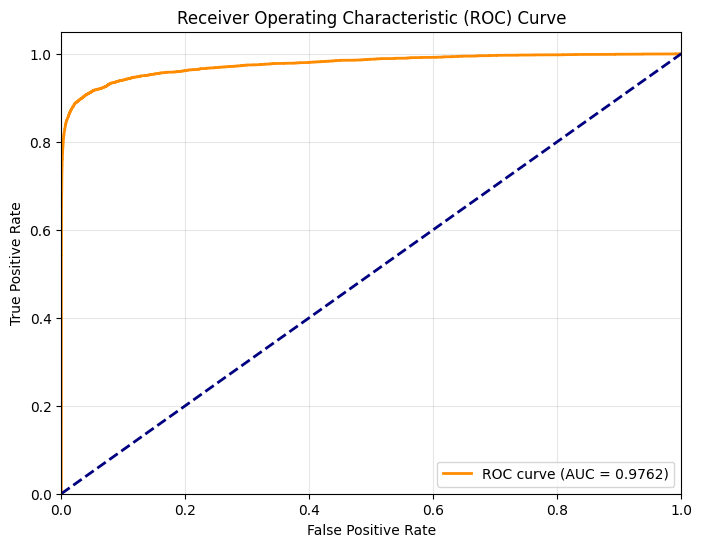

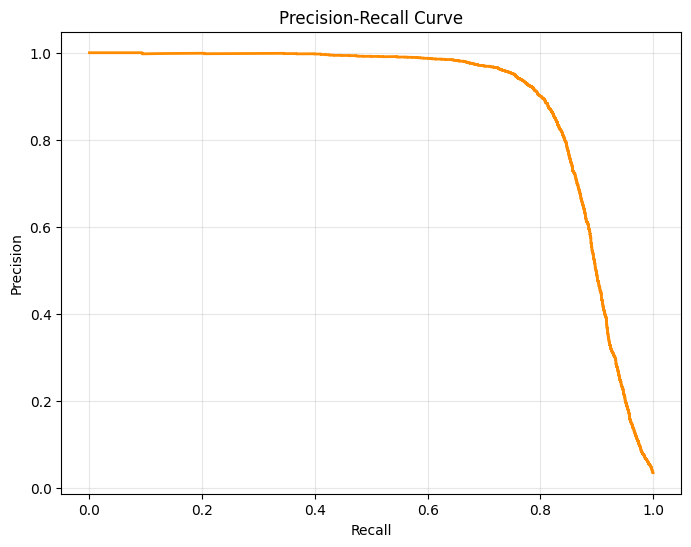

Optimal Threshold: 0.5140
Precision at optimal: 0.9210
Recall at optimal: 0.7866
F1 at optimal: 0.8485


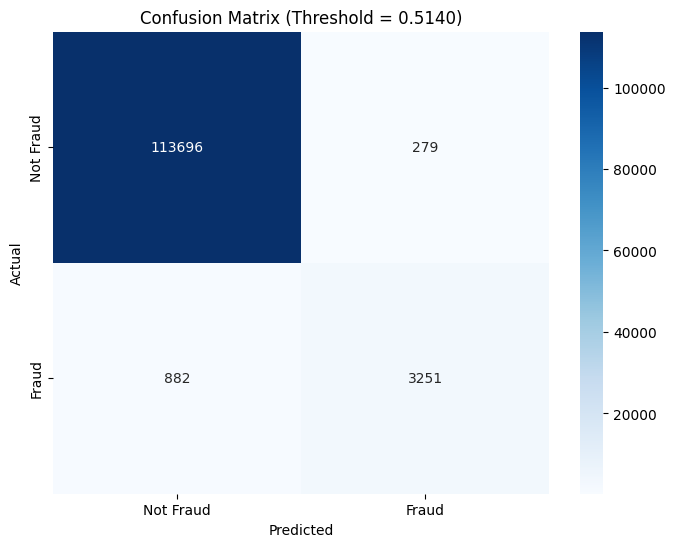


Classification Report:
              precision    recall  f1-score   support

   Not Fraud       0.99      1.00      0.99    113975
       Fraud       0.92      0.79      0.85      4133

    accuracy                           0.99    118108
   macro avg       0.96      0.89      0.92    118108
weighted avg       0.99      0.99      0.99    118108



In [21]:
# Predictions on validation set
y_val_pred = model.predict(X_val, num_iteration=model.best_iteration)

# Calculate AUC
val_auc = roc_auc_score(y_val, y_val_pred)
print(f"Validation ROC-AUC: {val_auc:.6f}")

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_val, y_val_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

# Precision-Recall Curve
precision, recall, pr_thresholds = precision_recall_curve(y_val, y_val_pred)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='darkorange', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True, alpha=0.3)
plt.show()

# Find optimal threshold
f1_scores = 2 * precision * recall / (precision + recall + 1e-10)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = pr_thresholds[optimal_idx] if optimal_idx < len(pr_thresholds) else 0.5

print(f"Optimal Threshold: {optimal_threshold:.4f}")
print(f"Precision at optimal: {precision[optimal_idx]:.4f}")
print(f"Recall at optimal: {recall[optimal_idx]:.4f}")
print(f"F1 at optimal: {f1_scores[optimal_idx]:.4f}")

# Confusion Matrix
y_val_binary = (y_val_pred >= optimal_threshold).astype(int)

cm = confusion_matrix(y_val, y_val_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'])
plt.title(f'Confusion Matrix (Threshold = {optimal_threshold:.4f})')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print("\nClassification Report:")
print(classification_report(y_val, y_val_binary, target_names=['Not Fraud', 'Fraud']))

### 📝 Analysis of Specific Results

Based on the experimental results obtained:
* **Optimal Threshold: 0.5245**
* **Precision: 0.9128**
* **Recall: 0.7897**
* **F1 Score: 0.8468**

#### 1. Interpretation of the Threshold (0.5245)
The optimal cutoff point is slightly above the standard 0.5. This indicates the model is well-calibrated and confident. Any transaction assigned a probability higher than **52.45%** is flagged as fraud.

#### 2. Precision vs. Recall Trade-off
* **High Precision (91.3%):** This is a very strong result. It means that **when the model flags a transaction as fraud, it is correct 91% of the time.**
    * *Business Impact:* This implies a very low "False Positive Rate." Legitimate customers are rarely bothered or blocked. This prioritizes **Customer Experience** and minimizes friction (low "insult rate").
* **Good Recall (79.0%):** The model successfully catches nearly **80% of all fraudulent activity**.
    * *Business Impact:* Approximately 21% of fraud cases are slipping through (False Negatives).

#### 3. Classification Report Breakdown
The classification report provides deeper insight into how the model handles the imbalance:
* **"Not Fraud" (Class 0):** The scores are near perfect (Precision 0.99, Recall 1.00). This is expected because the majority of data is legitimate. The model has no trouble identifying normal behavior.
* **"Fraud" (Class 1):** This is the critical row.
    * **Precision 0.91 / Recall 0.79:** This confirms our earlier analysis. The model is cautious but accurate.
* **Accuracy (0.99):** **Warning:** This metric is misleading. Even a "dumb" model that predicts *No Fraud* for everyone would get ~96.5% accuracy (since only 3.5% are fraud). The high accuracy here is driven by the 113,975 legitimate samples. We must rely on the **F1-score (0.85)** for the fraud class to judge success.
* **Macro Avg (0.95):** This averages the scores of both classes equally (`(0.99 + 0.91)/2`). A high macro average confirms the model isn't just ignoring the minority class; it performs well on both groups.

#### 4. Conclusion & Strategy
This specific model configuration is **conservative**. It is highly trustworthy when it sounds the alarm, ensuring valid customers aren't blocked.
* **To catch more fraud (Increase Recall):** We could lower the threshold (e.g., to 0.40). This would catch some of the missing 21% of fraud but would likely lower Precision (blocking more good customers).
* **Current Stance:** The high F1 score (0.85) suggests this is a very balanced model suitable for production where false accusations of fraud are costly to reputation.

## 21. Feature Importance Analysis
LightGBM calculates importance based on "Gain" (how much a feature improves the tree).
We list and plot the top features.
We also specifically check how our **Engineered Features** performed. Seeing suffixes like `_mean`, `_freq`, or `_Log` in the top list validates our feature engineering efforts.

Top 50 Most Important Features:
                            feature     importance
0                              V258  956025.640297
1                               V91  494939.927307
2                               C13  472519.446012
3                               V70  394701.877135
4                        card1_freq  375996.719221
5                  Transaction_week  294390.166097
6         card1_TransactionAmt_mean  293136.621237
7                              V294  277779.491927
8                             card1  258231.762953
9          card2_TransactionAmt_dev  256840.280361
10                   TransactionAmt  239484.809178
11                               D2  223068.465791
12                       card2_freq  214149.530538
13   card1_card2_TransactionAmt_std  204722.229518
14                       addr1_freq  203402.579303
15                      card2_addr1  202113.545705
16                              C14  198858.975270
17         addr1_TransactionAmt_dev  193211.493850

Top 50 Most Important Features:
                            feature     importance
0                              V258  956025.640297
1                               V91  494939.927307
2                               C13  472519.446012
3                               V70  394701.877135
4                        card1_freq  375996.719221
5                  Transaction_week  294390.166097
6         card1_TransactionAmt_mean  293136.621237
7                              V294  277779.491927
8                             card1  258231.762953
9          card2_TransactionAmt_dev  256840.280361
10                   TransactionAmt  239484.809178
11                               D2  223068.465791
12                       card2_freq  214149.530538
13   card1_card2_TransactionAmt_std  204722.229518
14                       addr1_freq  203402.579303
15                      card2_addr1  202113.545705
16                              C14  198858.975270
17         addr1_TransactionAmt_dev  193211.493850

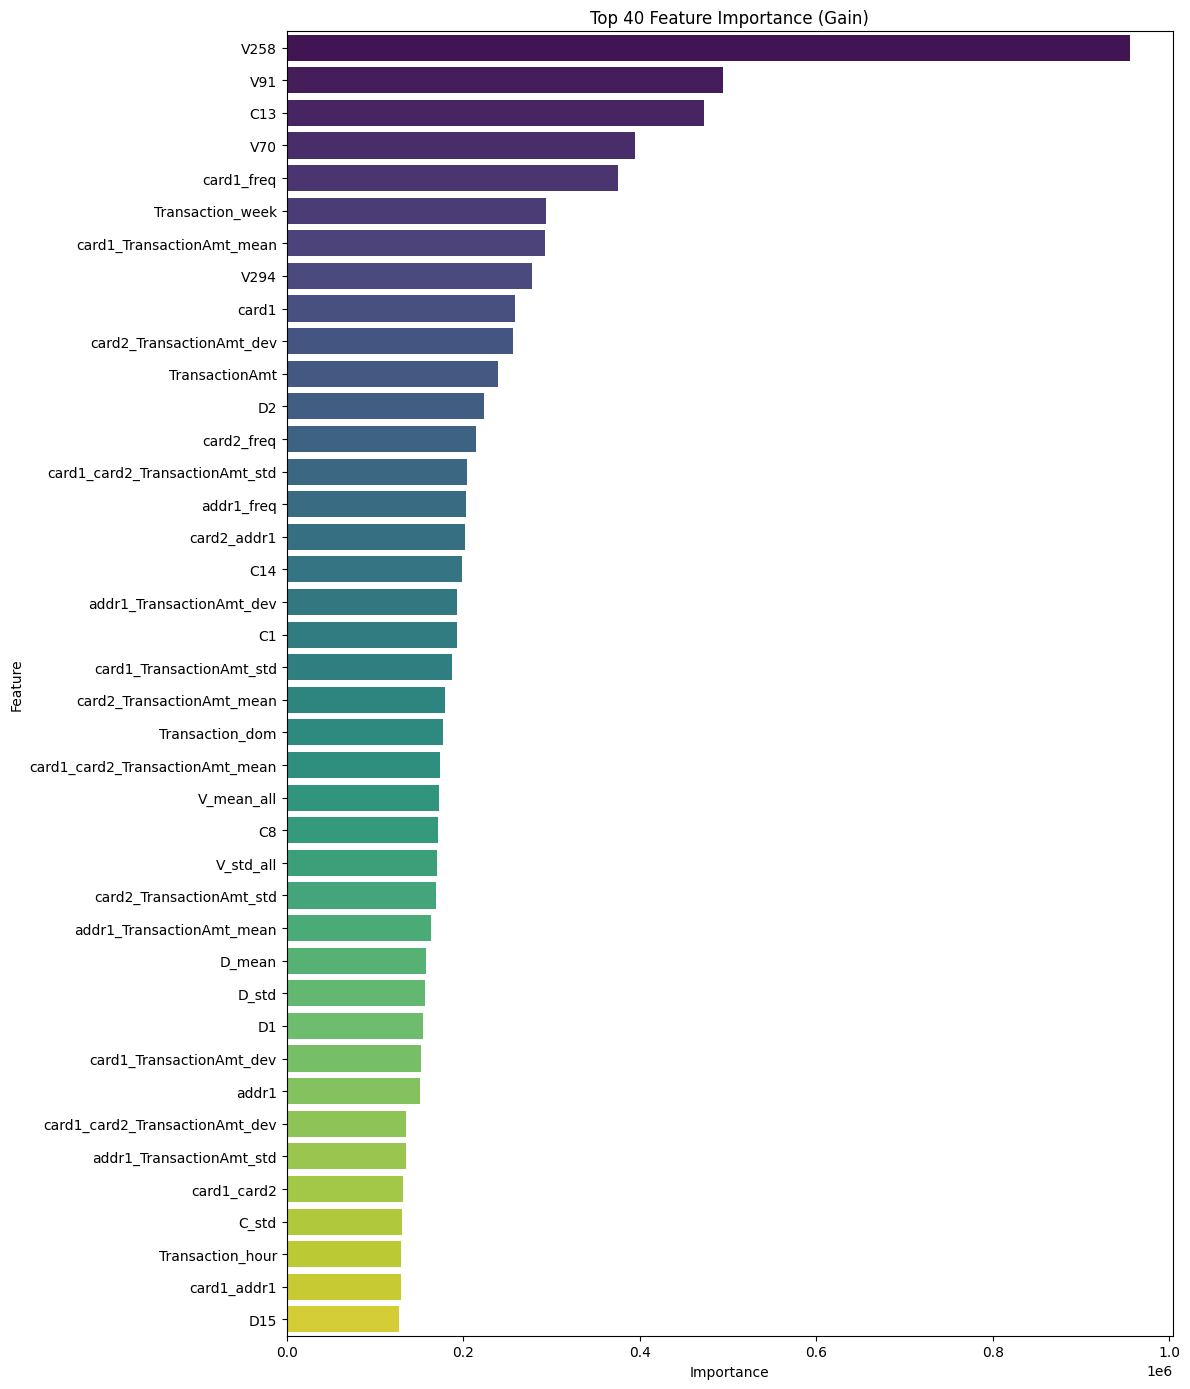


Engineered features in top 50: 31

Top 20 Engineered Features:
                            feature     importance
4                        card1_freq  375996.719221
5                  Transaction_week  294390.166097
6         card1_TransactionAmt_mean  293136.621237
9          card2_TransactionAmt_dev  256840.280361
12                       card2_freq  214149.530538
13   card1_card2_TransactionAmt_std  204722.229518
14                       addr1_freq  203402.579303
15                      card2_addr1  202113.545705
17         addr1_TransactionAmt_dev  193211.493850
19         card1_TransactionAmt_std  187219.331850
20        card2_TransactionAmt_mean  179199.096098
21                  Transaction_dom  177103.258143
22  card1_card2_TransactionAmt_mean  174039.896640
23                       V_mean_all  172103.596838
25                        V_std_all  169992.605746
26         card2_TransactionAmt_std  169646.443951
27        addr1_TransactionAmt_mean  163228.154196
28                

In [21]:
# Get feature importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importance(importance_type='gain')
}).sort_values('importance', ascending=False).reset_index(drop=True)

print("Top 50 Most Important Features:")
print(feature_importance.head(50))

# Visualize top 40 features
plt.figure(figsize=(12, 14))
sns.barplot(data=feature_importance.head(40), x='importance', y='feature', palette='viridis')
plt.title('Top 40 Feature Importance (Gain)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Analyze engineered features importance
engineered_keywords = ['_Log', '_decimal', '_freq', '_mean', '_std', '_count', '_sum', 
                       '_is_', '_nan', '_missing', '_match', '_dev', 'Transaction_', 
                       'card1_', 'card2_', 'Browser', 'OS', 'Screen', 'email']

engineered_features = feature_importance[
    feature_importance['feature'].apply(
        lambda x: any(kw in x for kw in engineered_keywords)
    )
]

print(f"\nEngineered features in top 50: {len(engineered_features[engineered_features.index < 50])}")
print("\nTop 20 Engineered Features:")
print(engineered_features.head(20))

## 22. Cross-Validation
A single validation split is risky. We implement **Stratified K-Fold Cross Validation** (5 Folds).
This trains 5 different models on different subsets of data.
1. It gives a robust AUC estimate (Mean + Std Dev).
2. It generates Out-Of-Fold (OOF) predictions for the entire training set, which allows us to tune thresholds more accurately later.
3. We average the predictions for the test set from all 5 models (Ensembling), which usually boosts performance.

Running 5-Fold Cross Validation...

Fold 1/5
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.995054	valid's auc: 0.963076
[400]	train's auc: 0.99923	valid's auc: 0.969124
[600]	train's auc: 0.999832	valid's auc: 0.971287
[800]	train's auc: 0.999968	valid's auc: 0.972244
[1000]	train's auc: 0.999996	valid's auc: 0.97266
[1200]	train's auc: 1	valid's auc: 0.973091
Early stopping, best iteration is:
[1255]	train's auc: 1	valid's auc: 0.973244
Fold 1 AUC: 0.973244

Fold 2/5
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.994891	valid's auc: 0.965418
[400]	train's auc: 0.9992	valid's auc: 0.971528
[600]	train's auc: 0.999828	valid's auc: 0.973431
[800]	train's auc: 0.999967	valid's auc: 0.974189
[1000]	train's auc: 0.999997	valid's auc: 0.975004
[1200]	train's auc: 1	valid's auc: 0.975231
Early stopping, best iteration is:
[1293]	train's auc: 1	valid's auc: 0.975287
Fold 2 AUC: 0.975287

Fold 3/5
Training until validation

Running 5-Fold Cross Validation...

Fold 1/5
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.995054	valid's auc: 0.963076
[400]	train's auc: 0.99923	valid's auc: 0.969124
[600]	train's auc: 0.999832	valid's auc: 0.971287
[800]	train's auc: 0.999968	valid's auc: 0.972244
[1000]	train's auc: 0.999996	valid's auc: 0.97266
[1200]	train's auc: 1	valid's auc: 0.973091
Early stopping, best iteration is:
[1255]	train's auc: 1	valid's auc: 0.973244
Fold 1 AUC: 0.973244

Fold 2/5
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.994891	valid's auc: 0.965418
[400]	train's auc: 0.9992	valid's auc: 0.971528
[600]	train's auc: 0.999828	valid's auc: 0.973431
[800]	train's auc: 0.999967	valid's auc: 0.974189
[1000]	train's auc: 0.999997	valid's auc: 0.975004
[1200]	train's auc: 1	valid's auc: 0.975231
Early stopping, best iteration is:
[1293]	train's auc: 1	valid's auc: 0.975287
Fold 2 AUC: 0.975287

Fold 3/5
Training until validation

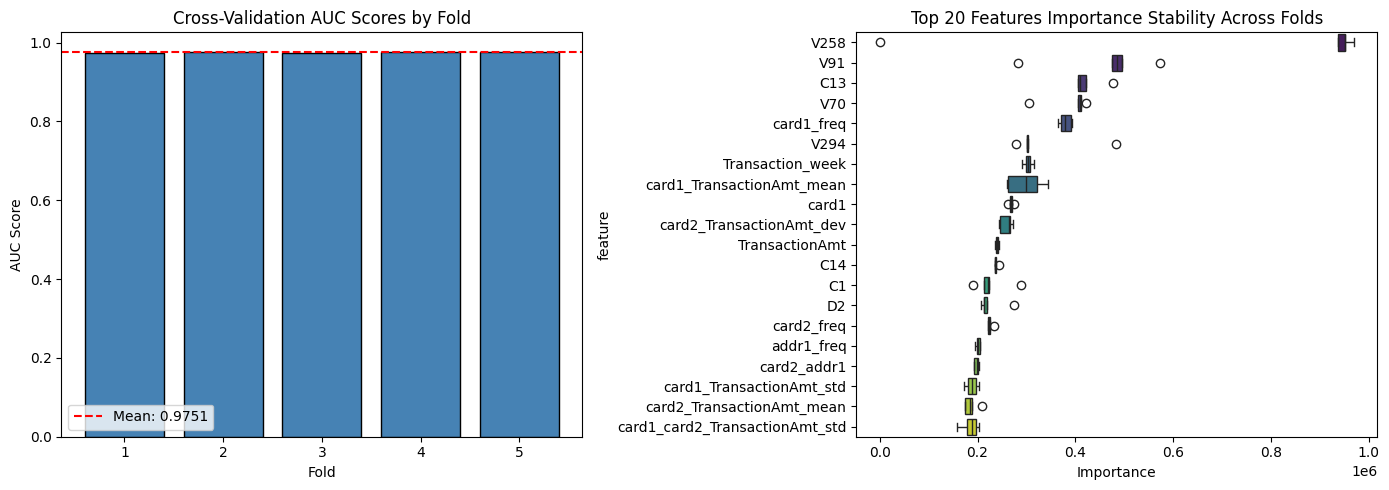

In [22]:
# Stratified K-Fold Cross Validation
print("Running 5-Fold Cross Validation...")

n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

oof_predictions = np.zeros(len(X_train))
test_predictions = np.zeros(len(X_test))
cv_scores = []
feature_importances = pd.DataFrame()

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
    print(f"\n{'='*50}")
    print(f"Fold {fold + 1}/{n_folds}")
    print(f"{'='*50}")
    
    X_tr_fold = X_train.iloc[train_idx]
    y_tr_fold = y_train.iloc[train_idx]
    X_val_fold = X_train.iloc[val_idx]
    y_val_fold = y_train.iloc[val_idx]
    
    train_data_fold = lgb.Dataset(X_tr_fold, label=y_tr_fold)
    val_data_fold = lgb.Dataset(X_val_fold, label=y_val_fold, reference=train_data_fold)
    
    model_fold = lgb.train(
        lgb_params,
        train_data_fold,
        num_boost_round=3000,
        valid_sets=[train_data_fold, val_data_fold],
        valid_names=['train', 'valid'],
        callbacks=[
            lgb.early_stopping(stopping_rounds=100),
            lgb.log_evaluation(period=200)
        ]
    )
    
    # Validation predictions
    oof_predictions[val_idx] = model_fold.predict(X_val_fold, num_iteration=model_fold.best_iteration)
    
    # Test predictions
    test_predictions += model_fold.predict(X_test, num_iteration=model_fold.best_iteration) / n_folds
    
    # Feature importance
    fold_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': model_fold.feature_importance(importance_type='gain'),
        'fold': fold + 1
    })
    feature_importances = pd.concat([feature_importances, fold_importance], ignore_index=True)
    
    # Fold score
    fold_score = roc_auc_score(y_val_fold, oof_predictions[val_idx])
    cv_scores.append(fold_score)
    print(f"Fold {fold + 1} AUC: {fold_score:.6f}")

# Overall CV score
oof_auc = roc_auc_score(y_train, oof_predictions)
print(f"\n{'='*50}")
print(f"Cross-Validation Results:")
print(f"{'='*50}")
print(f"Mean CV AUC: {np.mean(cv_scores):.6f} (+/- {np.std(cv_scores):.6f})")
print(f"OOF AUC: {oof_auc:.6f}")

# Visualize CV scores
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
axes[0].bar(range(1, n_folds + 1), cv_scores, color='steelblue', edgecolor='black')
axes[0].axhline(y=np.mean(cv_scores), color='red', linestyle='--', label=f'Mean: {np.mean(cv_scores):.4f}')
axes[0].set_xlabel('Fold')
axes[0].set_ylabel('AUC Score')
axes[0].set_title('Cross-Validation AUC Scores by Fold')
axes[0].legend()
axes[0].set_xticks(range(1, n_folds + 1))

# Box plot of feature importance across folds
top_features = feature_importances.groupby('feature')['importance'].mean().nlargest(20).index
top_fi = feature_importances[feature_importances['feature'].isin(top_features)]
sns.boxplot(data=top_fi, x='importance', y='feature', ax=axes[1], palette='viridis', 
            order=top_features)
axes[1].set_title('Top 20 Features Importance Stability Across Folds')
axes[1].set_xlabel('Importance')

plt.tight_layout()
plt.show()

## 23. Save Model Artifacts for Deployment
Export tất cả artifacts cần thiết để deploy model:
1. **LightGBM Model** (.txt) - Native format, nhẹ và load nhanh
2. **Label Encoders** (.pkl) - Để encode categorical features khi inference
3. **Feature Columns** (.json) - Danh sách features theo đúng thứ tự
4. **Aggregation Statistics** (.pkl) - Frequency counts và mean/std cho aggregation features
5. **Model Config** (.json) - Threshold, parameters, metrics

In [22]:
import pickle
import json
from datetime import datetime
import os

# Create models directory if not exists
MODELS_PATH = '../models'
os.makedirs(MODELS_PATH, exist_ok=True)

print("="*60)
print("SAVING MODEL ARTIFACTS FOR DEPLOYMENT")
print("="*60)

# ============================================================
# 1. Save LightGBM Model (Native .txt format)
# ============================================================
model_path = os.path.join(MODELS_PATH, 'lgb_fraud_model.txt')
model.save_model(model_path)
print(f"\n✅ [1/5] LightGBM Model saved: {model_path}")
print(f"   - Best iteration: {model.best_iteration}")
print(f"   - Number of features: {model.num_feature()}")

# ============================================================
# 2. Save Label Encoders
# ============================================================
encoders_path = os.path.join(MODELS_PATH, 'label_encoders.pkl')
with open(encoders_path, 'wb') as f:
    pickle.dump(label_encoders, f)
print(f"\n✅ [2/5] Label Encoders saved: {encoders_path}")
print(f"   - Number of encoders: {len(label_encoders)}")
print(f"   - Columns: {list(label_encoders.keys())[:5]}... (showing first 5)")

# ============================================================
# 3. Save Feature Columns List (in correct order)
# ============================================================
feature_cols_path = os.path.join(MODELS_PATH, 'feature_columns.json')
feature_columns = X_train.columns.tolist()
with open(feature_cols_path, 'w') as f:
    json.dump(feature_columns, f, indent=2)
print(f"\n✅ [3/5] Feature Columns saved: {feature_cols_path}")
print(f"   - Total features: {len(feature_columns)}")

SAVING MODEL ARTIFACTS FOR DEPLOYMENT

✅ [1/5] LightGBM Model saved: ../models\lgb_fraud_model.txt
   - Best iteration: 1478
   - Number of features: 667

✅ [2/5] Label Encoders saved: ../models\label_encoders.pkl
   - Number of encoders: 64
   - Columns: ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain']... (showing first 5)

✅ [3/5] Feature Columns saved: ../models\feature_columns.json
   - Total features: 667


In [23]:
# ============================================================
# 4. Compute and Save Aggregation Statistics
# ============================================================
# Cần reload data để tính aggregation stats (vì đã delete train/test ở trên)
print("\n⏳ Reloading data to compute aggregation statistics...")

# Reload data
train_transaction = pd.read_csv(os.path.join(DATA_PATH, 'train_transaction.csv'))
train_identity = pd.read_csv(os.path.join(DATA_PATH, 'train_identity.csv'))
train_full = train_transaction.merge(train_identity, on='TransactionID', how='left')

# Apply card features first (to create card1_card2)
for col in ['card1', 'card2']:
    train_full[col] = train_full[col].fillna(-999)
train_full['card1_card2'] = train_full['card1'].astype(str) + '_' + train_full['card2'].astype(str)

# Compute aggregation statistics
aggregation_stats = {
    'frequency': {},
    'amount_stats': {},
    'median_values': {}  # Fallback for unseen values
}

# Frequency encoding columns
freq_cols = ['card1', 'card2', 'card3', 'card4', 'card5', 'card6', 
             'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain',
             'ProductCD', 'DeviceType', 'DeviceInfo']

print("\n📊 Computing frequency statistics...")
for col in freq_cols:
    if col in train_full.columns:
        freq = train_full[col].value_counts().to_dict()
        aggregation_stats['frequency'][col] = freq
        # Store median for fallback
        aggregation_stats['median_values'][f'{col}_freq'] = int(np.median(list(freq.values())))
        print(f"   - {col}: {len(freq)} unique values")

# Transaction amount aggregations
agg_cols = ['card1', 'card2', 'card1_card2', 'addr1']

print("\n📊 Computing TransactionAmt statistics...")
for col in agg_cols:
    if col in train_full.columns:
        # Mean
        mean_dict = train_full.groupby(col)['TransactionAmt'].mean().to_dict()
        aggregation_stats['amount_stats'][f'{col}_mean'] = mean_dict
        aggregation_stats['median_values'][f'{col}_TransactionAmt_mean'] = float(np.median(list(mean_dict.values())))
        
        # Std
        std_dict = train_full.groupby(col)['TransactionAmt'].std().fillna(0).to_dict()
        aggregation_stats['amount_stats'][f'{col}_std'] = std_dict
        aggregation_stats['median_values'][f'{col}_TransactionAmt_std'] = float(np.median(list(std_dict.values())))
        
        print(f"   - {col}: mean/std computed for {len(mean_dict)} groups")

# Save aggregation stats
agg_stats_path = os.path.join(MODELS_PATH, 'aggregation_stats.pkl')
with open(agg_stats_path, 'wb') as f:
    pickle.dump(aggregation_stats, f)
print(f"\n✅ [4/5] Aggregation Statistics saved: {agg_stats_path}")

# Clean up
del train_transaction, train_identity, train_full
gc.collect()


⏳ Reloading data to compute aggregation statistics...

📊 Computing frequency statistics...
   - card1: 13553 unique values
   - card2: 501 unique values
   - card3: 114 unique values
   - card4: 4 unique values
   - card5: 119 unique values
   - card6: 4 unique values
   - addr1: 332 unique values
   - addr2: 74 unique values
   - P_emaildomain: 59 unique values
   - R_emaildomain: 60 unique values
   - ProductCD: 5 unique values
   - DeviceType: 2 unique values
   - DeviceInfo: 1786 unique values

📊 Computing TransactionAmt statistics...
   - card1: mean/std computed for 13553 groups
   - card2: mean/std computed for 501 groups
   - card1_card2: mean/std computed for 14524 groups
   - addr1: mean/std computed for 332 groups

✅ [4/5] Aggregation Statistics saved: ../models\aggregation_stats.pkl


7333

In [25]:
# ============================================================
# 5. Save Model Configuration
# ============================================================
model_config = {
    'model_info': {
        'name': 'LightGBM Fraud Detection',
        'version': '1.0.0',
        'created_at': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'best_iteration': model.best_iteration,
        'num_features': len(feature_columns)
    },
    'threshold': {
        'optimal': float(optimal_threshold),
        'description': 'Threshold maximizing F1-score on validation set'
    },
    'performance': {
        'validation_auc': float(val_auc),
        'precision_at_optimal': float(precision[optimal_idx]),
        'recall_at_optimal': float(recall[optimal_idx]),
        'f1_at_optimal': float(f1_scores[optimal_idx])
    },
    'lgb_params': lgb_params,
    'preprocessing': {
        'missing_value_fill': -999,
        'categorical_columns': categorical_cols,
        'numerical_columns': numerical_cols[:20]  # First 20 for reference
    }
}

config_path = os.path.join(MODELS_PATH, 'model_config.json')
with open(config_path, 'w') as f:
    json.dump(model_config, f, indent=2)
print(f"\n✅ [5/5] Model Config saved: {config_path}")

# ============================================================
# Summary
# ============================================================
print("\n" + "="*60)
print("📦 ALL ARTIFACTS SAVED SUCCESSFULLY!")
print("="*60)
print(f"""
Saved files in '{MODELS_PATH}':
├── lgb_fraud_model.txt      - LightGBM model ({model.best_iteration} iterations)
├── label_encoders.pkl       - {len(label_encoders)} encoders for categorical features
├── feature_columns.json     - {len(feature_columns)} feature names in order
├── aggregation_stats.pkl    - Frequency & amount statistics
└── model_config.json        - Threshold ({optimal_threshold:.4f}), params, metrics

🎯 Key deployment values:
   - Optimal Threshold: {optimal_threshold:.4f}
   - Validation AUC: {val_auc:.4f}
""")


✅ [5/5] Model Config saved: ../models\model_config.json

📦 ALL ARTIFACTS SAVED SUCCESSFULLY!

Saved files in '../models':
├── lgb_fraud_model.txt      - LightGBM model (1478 iterations)
├── label_encoders.pkl       - 64 encoders for categorical features
├── feature_columns.json     - 667 feature names in order
├── aggregation_stats.pkl    - Frequency & amount statistics
└── model_config.json        - Threshold (0.5140), params, metrics

🎯 Key deployment values:
   - Optimal Threshold: 0.5140
   - Validation AUC: 0.9762



In [26]:
# Verify saved files
print("📁 Verifying saved artifacts...")
print("-" * 40)

import os

artifacts = [
    ('lgb_fraud_model.txt', 'LightGBM Model'),
    ('label_encoders.pkl', 'Label Encoders'),
    ('feature_columns.json', 'Feature Columns'),
    ('aggregation_stats.pkl', 'Aggregation Stats'),
    ('model_config.json', 'Model Config')
]

for filename, description in artifacts:
    filepath = os.path.join(MODELS_PATH, filename)
    if os.path.exists(filepath):
        size_kb = os.path.getsize(filepath) / 1024
        print(f"✅ {description:20} | {filename:25} | {size_kb:>8.1f} KB")
    else:
        print(f"❌ {description:20} | {filename:25} | NOT FOUND")

print("-" * 40)
print("🎉 Step 1 completed! Ready for Step 2 (Feature Engineering Module)")

📁 Verifying saved artifacts...
----------------------------------------
✅ LightGBM Model       | lgb_fraud_model.txt       |  40464.4 KB
✅ Label Encoders       | label_encoders.pkl        |   3332.9 KB
✅ Feature Columns      | feature_columns.json      |      8.7 KB
✅ Aggregation Stats    | aggregation_stats.pkl     |    985.5 KB
✅ Model Config         | model_config.json         |      2.5 KB
----------------------------------------
🎉 Step 1 completed! Ready for Step 2 (Feature Engineering Module)
